This notebook is used for initial data analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import master_bar, progress_bar

# Get access to all the files in the repository
cwd = os.getcwd()
parentDir = os.path.dirname( cwd )
sys.path.append(parentDir)


First convert all the .txt files into .npy files for faster access and smaller footprint

In [2]:
pointCloudDir = os.path.join( parentDir, "data", "raw", "cloud" )

# Create a list of paths to all the .txt files of pointclouds
txt_files = [os.path.join( pointCloudDir, file ) for file in os.listdir( pointCloudDir ) if file.endswith(".txt") ]

for txt_file in txt_files:
    # Load the cloud and convert it to .npy
    cloud = np.loadtxt(txt_file)
    npy_file = txt_file.replace(".txt", ".npy") # New path in same directory
    np.save(npy_file, cloud)

print("Finished conversion")

Finished conversion


Define a function that voxelizes a pointcloud and returns the grid as well as the fraction of occupied voxels. Note that this is not the final way of voxelizing but simply a method for analyzing occupancy

In [4]:
def create_voxel_grid( cloud, voxel_size ):
    """
        This function creates a voxel grid of a pointcloud and returns the fraction of voxels being occupied.
        args:
            cloud:      a point cloud in a [Nx3] array of coordinates [meters]
            voxel_size: the size of the voxels [meters]
        returns:
            voxel_grid: a boolean grid of voxels which indicates which voxels are occupied
            occupation: a float representing the fraction of occupied voxels
    """
    # First create an array of voxel indices, where each voxel indice is a 3d array containing its bottom left corner, meaning something like [-1,2,5].
    # These are not coordinates in the original data but are multitudes of voxel_size in the original coordinate system
    voxel_indices = np.floor( cloud / voxel_size ).astype(np.int32)
    # Shift the grid to never include indices smaller than 0
    min_indices = np.min(voxel_indices, axis=0)
    voxel_indices -= min_indices
    # Now get the maximum size in each dimension
    grid_shape = np.max( voxel_indices, axis=0 ) + 1 # Include voxel at maximum index
    voxel_grid = np.zeros( grid_shape, dtype=bool )

    # Now set the grid to true where voxels are occupied
    for idx in voxel_indices:
        voxel_grid[tuple(idx)] = True

    # Now get the fraction of occupied voxels
    num_occupied_voxels = np.sum( voxel_grid )
    total_voxels = voxel_grid.size

    occupation = num_occupied_voxels / total_voxels

    return voxel_grid, occupation
    


In [8]:
pointCloudDir = os.path.join( parentDir, "data", "raw", "cloud" )

exampleCloud = os.path.join(pointCloudDir, "33_3.npy")

cloud = np.load(exampleCloud)

grid, occ = create_voxel_grid( cloud, 0.01 )

print(grid)
print(occ)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

Define and run a function that creates a scatter plot where the fraction of occupied voxels is plotted against the number of points of a cloud

In [9]:
def plot_grid_occupation(cloudDir, voxelSizes, plotSavePath=None):
    cloudFiles = [os.path.join(cloudDir, file) for file in os.listdir(cloudDir) if file.endswith(".npy")]
    
    print("Voxelizing Clouds...")
    
    # Check if voxelSizes is a single value or a list of sizes
    if isinstance(voxelSizes, list) and len(voxelSizes) == 4:
        # Handle the 2x2 subplot case
        fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=False)
        axes = axes.flatten()  # Flatten axes for easy iteration
        
        for i, voxelSize in enumerate(voxelSizes):
            print(f"Voxelization with size {voxelSize}m")
            cloudSizes = []
            cloudOccupations = []

            for file in progress_bar(cloudFiles):
                cloud = np.load(file)

                cloudSizes.append(len(cloud))
                _, occupation = create_voxel_grid(cloud=cloud, voxel_size=voxelSize)
                cloudOccupations.append(occupation)

            # Plot the results in the corresponding subplot
            ax = axes[i]
            ax.scatter(cloudSizes, cloudOccupations, marker="x", color="red", alpha=0.8)
            ax.set_title(f"Voxel Size: {voxelSize}m")
            ax.set_xlabel("# of points")
            ax.set_ylabel("Fraction occupied voxels")
            ax.grid()

        # Set a global title for the figure
        fig.suptitle("Voxel Occupancy for Different Voxel Sizes", fontsize=16)

        # Adjust layout for better spacing
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title

    else:
        # Handle the single voxel size case (previous behavior)
        cloudSizes = []
        cloudOccupations = []

        for file in progress_bar(cloudFiles):
            cloud = np.load(file)

            cloudSizes.append(len(cloud))
            _, occupation = create_voxel_grid(cloud=cloud, voxel_size=voxelSizes)
            cloudOccupations.append(occupation)

        # Plot the results for the single voxel size
        plt.figure(figsize=(8, 6))
        plt.scatter(cloudSizes, cloudOccupations, marker="x", color="red", alpha=0.8)
        plt.xlabel("# of points")
        plt.ylabel("Fraction occupied voxels")
        plt.title(f"Fraction of occupied voxels for voxel size {voxelSizes}m")
        plt.grid()

    # Save the plot if a path is provided
    if plotSavePath:
        if isinstance(voxelSizes, list):
            voxelSizesCM = [int(vs * 100) for vs in voxelSizes]
            plt.savefig(os.path.join(plotSavePath, f"Occupation_raw_{voxelSizesCM[0]}cm_{voxelSizesCM[1]}cm_{voxelSizesCM[2]}cm_{voxelSizesCM[3]}cm.png"), dpi=300)
        else:
            voxelSizeCM = int(voxelSizes * 100)
            plt.savefig(os.path.join(plotSavePath, f"Occupation_raw_{voxelSizeCM}cm.png"), dpi=300)

    # Show the plot
    plt.show()


Voxelizing Clouds...
Voxelization with size 0.1m


Voxelization with size 0.05m


Voxelization with size 0.02m


Voxelization with size 0.01m


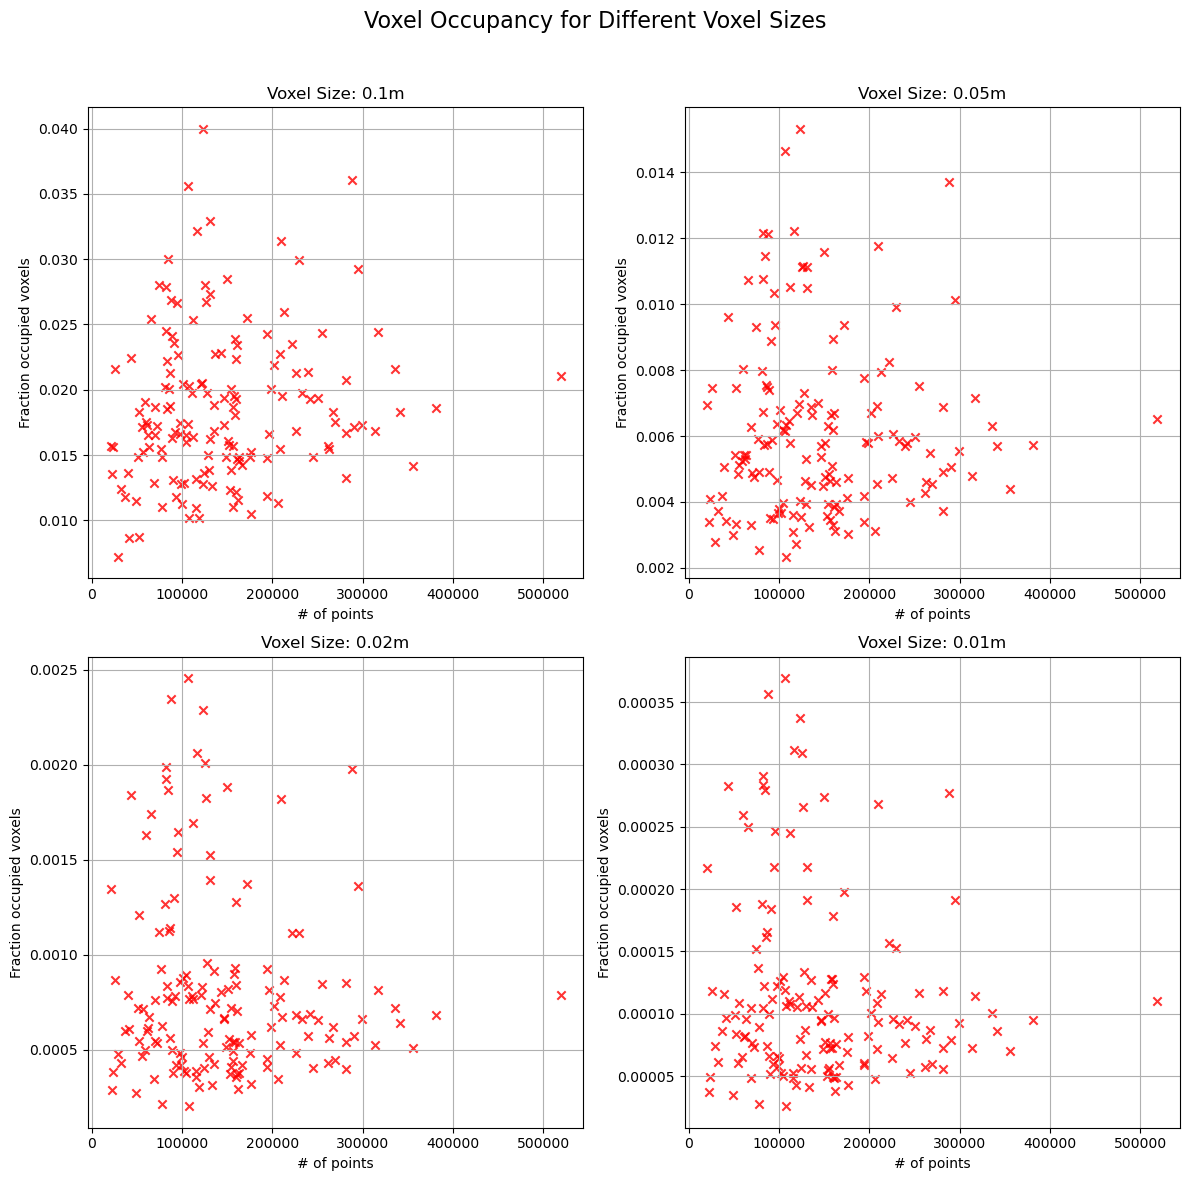

In [10]:
pointCloudDir = os.path.join( parentDir, "data", "raw", "cloud" )

plotSavePath = os.path.join( parentDir, "plots", "DataAnalysis")

plot_grid_occupation( cloudDir=pointCloudDir, voxelSizes=[0.1, 0.05, 0.02, 0.01], plotSavePath=plotSavePath )